In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-01-16 20:06:27 Configured OSMnx 1.1.1
2023-01-16 20:06:27 HTTP response caching is on


In [2]:
city = 'Guadalajara' #Ejemplo acotado a Guadalajara

## Download data from db

Whole metropolitan area

(6003, 226)


<AxesSubplot:>

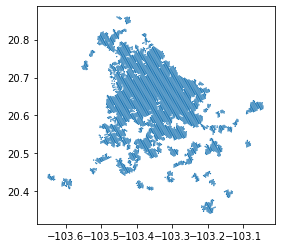

In [4]:
# download hexagons with pop data
hex_schema = 'censo'
hex_folder = 'hex_censo_mza_2020_res9'

query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"metropolis\" LIKE \'{city}\'"
hex_pop = aup.gdf_from_query(query, geometry_col='geometry')

print(hex_pop.shape)
hex_pop.head(2)
hex_pop.plot()

2km from Adolfo Lopez Mateos

In [20]:
hex_schema = 'segundopiso'
hex_folder = 'censo1020_mza_hexres9_buffer2km'

query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"city\" LIKE \'{city}\'"
hex_pop_2km = aup.gdf_from_query(query, geometry_col='geometry')
print(hex_pop_2km.shape)

(853, 434)


1km from Adolfo Lopez Mateos

In [19]:
hex_schema = 'segundopiso'
hex_folder = 'censo1020_mza_hexres9_buffer1km'

query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"city\" LIKE \'{city}\'"
hex_pop_1km = aup.gdf_from_query(query, geometry_col='geometry')
print(hex_pop_1km.shape)

(472, 434)


500m from Adolfo Lopez Mateos

In [18]:
hex_schema = 'segundopiso'
hex_folder = 'censo1020_mza_hexres9_buffer500m'

query = f"SELECT * FROM {hex_schema}.{hex_folder} WHERE \"city\" LIKE \'{city}\'"
hex_pop_500m = aup.gdf_from_query(query, geometry_col='geometry')
print(hex_pop_500m.shape)

(272, 434)


## Data analysis

### Divide north/south

In [79]:
hex_pop_500m_nte = hex_pop_500m[hex_pop_500m['ubicacion']=='Norte del periferico']
hex_pop_500m_sur = hex_pop_500m[hex_pop_500m['ubicacion']=='Sur del periferico']

hex_pop_1km_nte = hex_pop_1km[hex_pop_1km['ubicacion']=='Norte del periferico']
hex_pop_1km_sur = hex_pop_1km[hex_pop_1km['ubicacion']=='Sur del periferico']

hex_pop_2km_nte = hex_pop_2km[hex_pop_2km['ubicacion']=='Norte del periferico']
hex_pop_2km_sur = hex_pop_2km[hex_pop_2km['ubicacion']=='Sur del periferico']

## Prueba con iteración

In [149]:
hexs_lst = [hex_pop_500m_nte,hex_pop_500m_sur,hex_pop_1km_nte,hex_pop_1km_sur,hex_pop_2km_nte,hex_pop_2km_sur,hex_pop]
hexs_strlst = ['hex_pop_500m_nte','hex_pop_500m_sur','hex_pop_1km_nte','hex_pop_1km_sur','hex_pop_2km_nte','hex_pop_2km_sur','hex_pop']
            
variable_lst = ['pobtot', 'vivtot', 'vph_autom', '10_pobtot', '10_vivtot', '10_vph_autom',]

summ_df = pd.DataFrame()

a = 0

for hexs in hexs_lst:
    for field in hexs:
        for variable in variable_lst:
            if field == variable:
                summ_df.loc[hexs_strlst[a],field] = hexs[field].sum()
    a = a + 1

summ_df

,pobtot,vivtot,vph_autom,10_pobtot,10_vivtot,10_vph_autom
hex_pop_500m_nte,92453.0,38552.0,27440.0,94426.0,34509.0,24037.0
hex_pop_500m_sur,50426.0,17539.0,9961.0,44640.0,13777.0,7033.0
hex_pop_1km_nte,185143.0,75484.0,52176.0,195294.0,69787.0,47185.0
hex_pop_1km_sur,98745.0,34490.0,20200.0,81976.0,24991.0,13169.0
hex_pop_2km_nte,383234.0,149828.0,97463.0,399634.0,137374.0,88773.0
hex_pop_2km_sur,189554.0,66015.0,39024.0,154608.0,47384.0,25186.0
hex_pop,5120219.0,1732948.0,802301.0,NaN,NaN,NaN


## Calculate cambio en %viv con auto

In [152]:
summ_df['%vivconauto'] = (summ_df['vph_autom'] / summ_df['vivtot'])*100
summ_df['10_%vivconauto'] = (summ_df['10_vph_autom'] / summ_df['10_vivtot'])*100
summ_df['%vivconauto_10_20'] = summ_df['%vivconauto'] - summ_df['10_%vivconauto']

summ_df

,pobtot,vivtot,vph_autom,10_pobtot,10_vivtot,10_vph_autom,%vivconauto,10_%vivconauto,%vivconauto_10_20
hex_pop_500m_nte,92453.0,38552.0,27440.0,94426.0,34509.0,24037.0,71.176593,69.654293,1.522300
hex_pop_500m_sur,50426.0,17539.0,9961.0,44640.0,13777.0,7033.0,56.793432,51.048850,5.744582
hex_pop_1km_nte,185143.0,75484.0,52176.0,195294.0,69787.0,47185.0,69.121933,67.612879,1.509054
hex_pop_1km_sur,98745.0,34490.0,20200.0,81976.0,24991.0,13169.0,58.567701,52.694970,5.872731
hex_pop_2km_nte,383234.0,149828.0,97463.0,399634.0,137374.0,88773.0,65.049924,64.621399,0.428525
hex_pop_2km_sur,189554.0,66015.0,39024.0,154608.0,47384.0,25186.0,59.113838,53.152963,5.960875
hex_pop,5120219.0,1732948.0,802301.0,NaN,NaN,NaN,46.296888,NaN,NaN
